In [1]:
from os import environ, path
import pandas as pd
import numpy as np

# DATA_PATH = environ.get('DATA_PATH', '../data/')
%matplotlib inline

In [2]:
deliveries_data = pd.read_csv(
    '/kaggle/input/doordash-takehome/historical_data.csv', 
    parse_dates=['created_at', 'actual_delivery_time'])
deliveries_data['duration'] = (deliveries_data.actual_delivery_time - deliveries_data.created_at).dt.total_seconds()

In [3]:
deliveries_data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'duration'],
      dtype='object')

In [4]:
deliveries_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


## Clean data

In [5]:
date_outliers_threshold = pd.to_datetime('2014-12-31') 
duration_outliers_threshold = 60*60*6  # 6h
cleaned_data = deliveries_data[
    deliveries_data.created_at > date_outliers_threshold
][
    deliveries_data.duration < duration_outliers_threshold
].dropna(
    how='any', 
    subset=[
        'duration', 
        'market_id', 
        'store_primary_category',
        'total_onshift_dashers',
        'total_busy_dashers',
        'total_outstanding_orders'
    ],
)
print(deliveries_data.shape, '->', cleaned_data.shape)

(197428, 17) -> (176453, 17)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<AxesSubplot:ylabel='Frequency'>

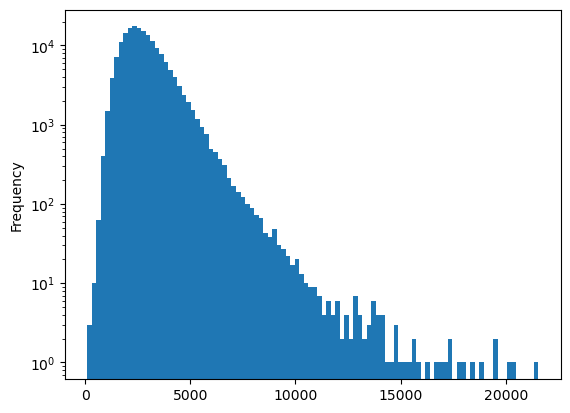

In [6]:
cleaned_data.duration.plot.hist(bins=100, log=True)

In [7]:
integer_columns = [
    'market_id',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
]
for column in integer_columns:
    cleaned_data[column] = cleaned_data[column].astype('int32')

## Features extraction

In [8]:
import sys
# sys.path.append('/home/michal/PycharmProjects/doordash/doordash')
from app.features_extractors.calendar import extract_calendar_features
from app.features_extractors.categorical import extract_categorical_features, generate_encoders
from app.features_extractors.numerical import extract_numerical_features
from app.features_extractors.time import extract_time_features

ModuleNotFoundError: No module named 'app'

### Basic

In [ ]:
basic_features = extract_numerical_features(cleaned_data)
basic_features.head()

In [ ]:
pd.DataFrame(cleaned_data.order_protocol).dropna().info()

### Categories

In [ ]:
encoders = generate_encoders(cleaned_data)

In [ ]:
categorical_features = extract_categorical_features(cleaned_data, encoders)
categorical_features.head()

### Calendar

In [ ]:
calendar_features = extract_calendar_features(cleaned_data)
calendar_features.head()

### Time

In [ ]:
time_features = extract_time_features(cleaned_data)
time_features.head()

### Features summary

In [ ]:
features = pd.concat([
    basic_features,
    categorical_features,
    calendar_features,
    time_features,
], axis=1)

## Target

In [ ]:
target = cleaned_data.reindex(columns=['duration'])
# target = pd.DataFrame(
#     MinMaxScaler().fit_transform(target), 
#     columns=['minmax_scaled_duration'], 
#     index=cleaned_data.index)

## Save prepared data

In [ ]:
dataset = pd.concat([
    features,
    target
], axis=1)
dataset

In [ ]:
dataset.to_csv(path.join(DATA_PATH, 'cleaned_data.csv'))

In [ ]:
import pickle

In [ ]:
encoders_file_path = path.join(DATA_PATH, 'cleaned_data_encoders.pickle')
pickle.dump(encoders, open(encoders_file_path, "wb"))